In [32]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler

pd.options.mode.chained_assignment = None

In [77]:
data = pd.read_excel('./2023 Analytics Internship Problem Dataset.xlsx')
df = data.copy()

### Read-in data and explore column types that may be useful for predicting induced vertical break

Columns that may be particularly useful are ones pertaining to velocity and spin rates. These numerical columns should be somewhat correlated with induced vertical break and should therefore serve as valuable predictors.

In [4]:
df.head()

,GAME_CODE,PITCHER_KEY,THROW_SIDE_KEY,BAT_SIDE_KEY,INNING_KEY,BATTER_IN_INNING_KEY,PITCH_NUMBER,CURRENT_BALLS,CURRENT_STRIKES,PITCH_RESULT_KEY,...,1BO,2BO,3BO,RELEASE_HEIGHT,RELEASE_SIDE,RELEASE_EXTENSION,HORIZONTAL_BREAK,INDUCED_VERTICAL_BREAK,VERTICAL_APPROACH_ANGLE,HORIZONTAL_APPROACH_ANGLE
0,2.022041e+18,A,R,L,1,1,1.0,0,0,BallCalled,...,0,0,0,5.93951,-1.22872,6.20612,-10.95070,21.192101,-6.04305,0.641485
1,2.022041e+18,A,R,L,1,1,2.0,1,0,BallCalled,...,0,0,0,5.95526,-1.27099,5.99715,-14.71020,19.499399,-3.44248,-1.982280
2,2.022041e+18,A,R,L,1,1,3.0,2,0,StrikeCalled,...,0,0,0,5.93761,-1.26223,6.19446,-10.51120,21.945700,-4.40359,-0.820934
3,2.022041e+18,A,R,L,1,1,4.0,2,1,BallCalled,...,0,0,0,5.91260,-0.94403,5.88159,7.38122,-18.108700,-12.81380,2.257720
4,2.022041e+18,A,R,L,1,1,5.0,3,1,BallCalled,...,0,0,0,5.97554,-1.24500,6.32453,-7.92814,17.101601,-2.50208,-1.018460


In [5]:
list(df.columns)

['GAME_CODE',
 'PITCHER_KEY',
 'THROW_SIDE_KEY',
 'BAT_SIDE_KEY',
 'INNING_KEY',
 'BATTER_IN_INNING_KEY',
 'PITCH_NUMBER',
 'CURRENT_BALLS',
 'CURRENT_STRIKES',
 'PITCH_RESULT_KEY',
 'EVENT_RESULT_KEY',
 'PITCH_TYPE_KEY',
 'RELEASE_SPEED',
 'PLATE_SPEED',
 'SPIN_RATE',
 'SPIN_DIRECTION',
 'SZ_TOP',
 'SZ_BOTTOM',
 'PLATE_X',
 'PLATE_Z',
 'B',
 'S',
 'O',
 'BU',
 'FB',
 'GB',
 'LD',
 'PU',
 '1BO',
 '2BO',
 '3BO',
 'RELEASE_HEIGHT',
 'RELEASE_SIDE',
 'RELEASE_EXTENSION',
 'HORIZONTAL_BREAK',
 'INDUCED_VERTICAL_BREAK',
 'VERTICAL_APPROACH_ANGLE',
 'HORIZONTAL_APPROACH_ANGLE']

### Given the column names above, it makes sense to subset the data to only those that would be valuable in predicting the vertical break.

These columns include:
- Release speed
- Plate speed
- Spin rate
- Spin direction
- Horizontal break
- Induced vertical break (necessary to use for training)
- Vertical approach angle
- Horizontal approach angle

Once I subset the dataframe down to these columns I will produce a correlation matrix to determine if we should shrink the set down further.

In [6]:
subsetted_columns = ['PITCHER_KEY','RELEASE_SPEED','PLATE_SPEED','SPIN_RATE','SPIN_DIRECTION','HORIZONTAL_BREAK',
                    'INDUCED_VERTICAL_BREAK','VERTICAL_APPROACH_ANGLE','HORIZONTAL_APPROACH_ANGLE']

In [17]:
df = df[subsetted_columns]

<AxesSubplot:>

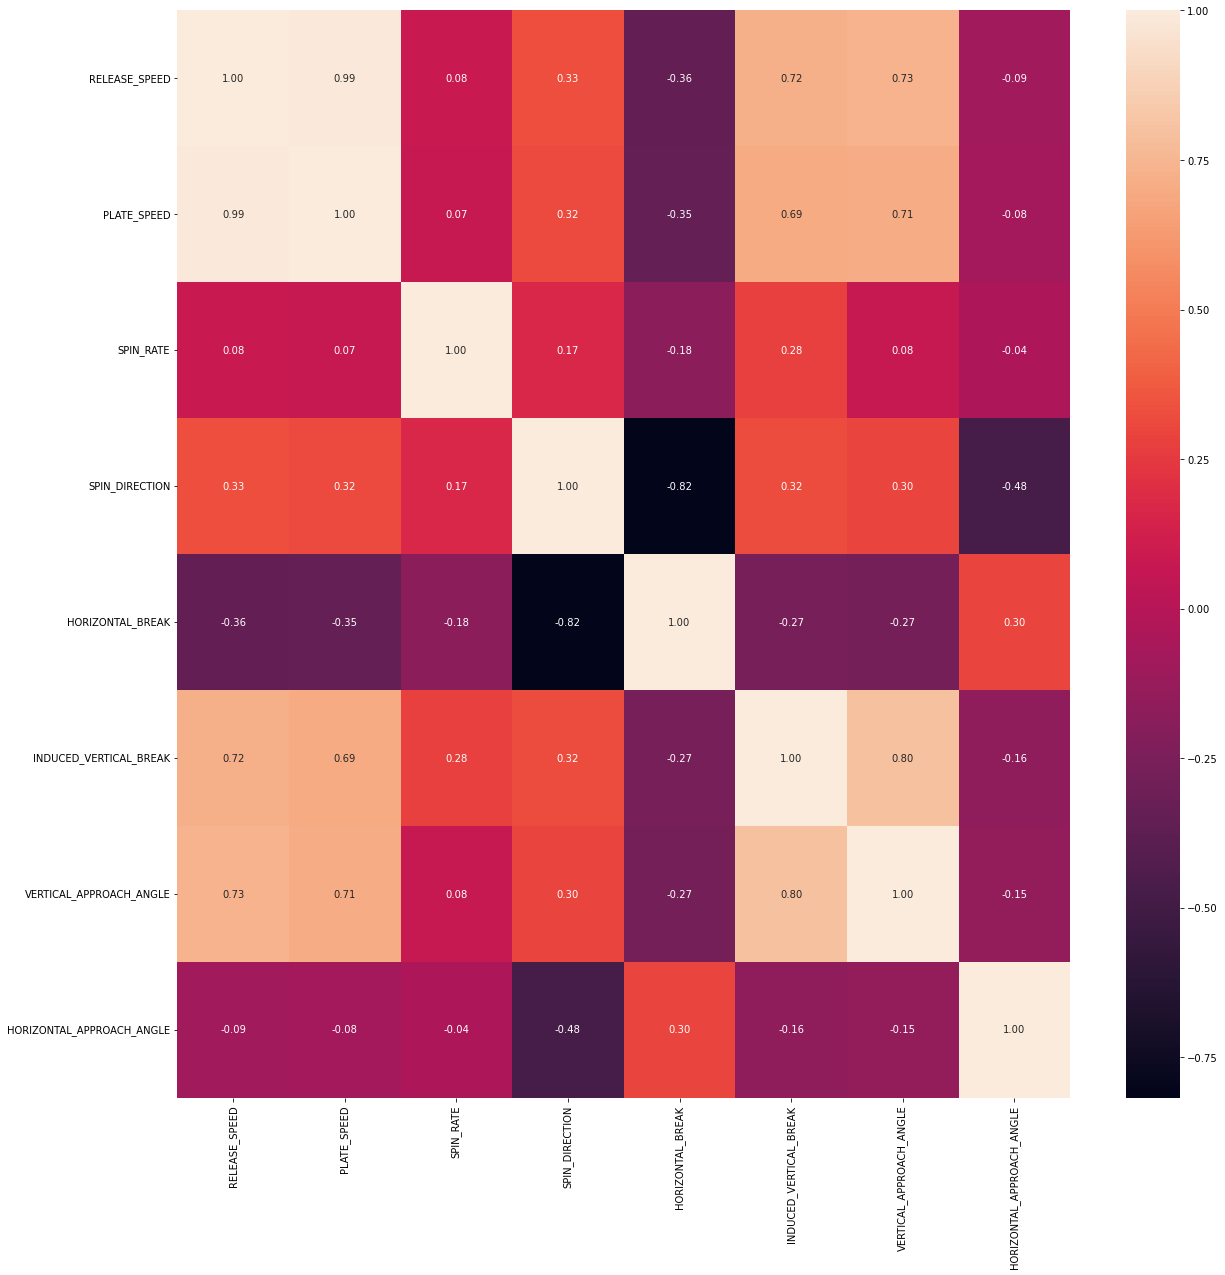

In [18]:
plt.figure(figsize = (20,20))
sns.heatmap(df.corr(),annot = True, fmt=".2f")

### Release speed and plate speed are almost identically correlated (pretty obviously), so removing one of them to prevent multi-colinearity would be a good idea. For the sake of this analysis, we will proceed with release speed but the two are nearly interchangable. It appears as if horizontal approach angle is not very correlated with induced vertical break so we will drop that as well. We will keep the rest and move forward to predictions.

In [19]:
correlation_reduction = ['PITCHER_KEY','RELEASE_SPEED','SPIN_RATE','SPIN_DIRECTION','HORIZONTAL_BREAK',
                         'INDUCED_VERTICAL_BREAK','VERTICAL_APPROACH_ANGLE']

In [20]:
df = df[correlation_reduction]

### We will first determine if there is a large enough sample to do predictions for induced vertical break based on each pitcher's history. 

In [66]:
pitcher_a = df[df['PITCHER_KEY']=='A']
pitcher_a.drop(columns = 'PITCHER_KEY',inplace = True)
pitcher_b = df[df['PITCHER_KEY']=='B']
pitcher_b.drop(columns = 'PITCHER_KEY',inplace = True)

In [53]:
pitcher_a.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2037 entries, 0 to 3928
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   RELEASE_SPEED            2037 non-null   float64
 1   SPIN_RATE                2031 non-null   float64
 2   SPIN_DIRECTION           2028 non-null   float64
 3   HORIZONTAL_BREAK         2030 non-null   float64
 4   INDUCED_VERTICAL_BREAK   1317 non-null   float64
 5   VERTICAL_APPROACH_ANGLE  2037 non-null   float64
dtypes: float64(6)
memory usage: 111.4 KB


In [54]:
pitcher_b.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1962 entries, 79 to 3998
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   RELEASE_SPEED            1962 non-null   float64
 1   SPIN_RATE                1962 non-null   float64
 2   SPIN_DIRECTION           1960 non-null   float64
 3   HORIZONTAL_BREAK         1960 non-null   float64
 4   INDUCED_VERTICAL_BREAK   1299 non-null   float64
 5   VERTICAL_APPROACH_ANGLE  1962 non-null   float64
dtypes: float64(6)
memory usage: 107.3 KB


### Model Type Determination 

With 1317 and 1299 pitches of data for pitchers A and B, respectively, I feel it is safe to use each pitcher's history for predictions. By that I mean I will create two training datasets only consisting of each pitcher's pitch data and use that to train an individualized model for each pitcher. This is opposed to using the plethora of other data available in the file to train a more generic model. My rationale for doing this is the sample size is large enough that we can still adequately test whatever model I build (in this case it will be a random forest). I also believe the personalized nature of the model will create more accurate predictions than a generic model that includes all possible vertical breaks from all pitchers of different quality/caliber. It could be possible to build a similarity score to find other pitchers in the dataset that are similar to pitchers A and B and use their data to also feed the model but that is outside the scope of this analysis.

In [67]:
pitcher_a_train = pitcher_a.dropna(subset='INDUCED_VERTICAL_BREAK')
pitcher_a_predict = pitcher_a.loc[pitcher_a['INDUCED_VERTICAL_BREAK'].isna()]

pitcher_b_train = pitcher_b.dropna(subset='INDUCED_VERTICAL_BREAK')
pitcher_b_predict = pitcher_b.loc[pitcher_b['INDUCED_VERTICAL_BREAK'].isna()]

### Let's take one more look at the correlation matrix to ensure the variables we have down-selected to are appropriate.

Based on the scores for each variable they do seem appropriate for predicting induced vertical break for each pitcher. We shall therefore proceed with creating a random forest for predictions. My rationale for using a random forest is I believe it will be an adequate solution to the given problem and you can still draw insight into factor importance from the random forest model (i.e. it is not a complete black box). In the context of this analysis, I will not delve further into the features that are important in the forest but it is available should that be of interest for future studies. 

<AxesSubplot:>

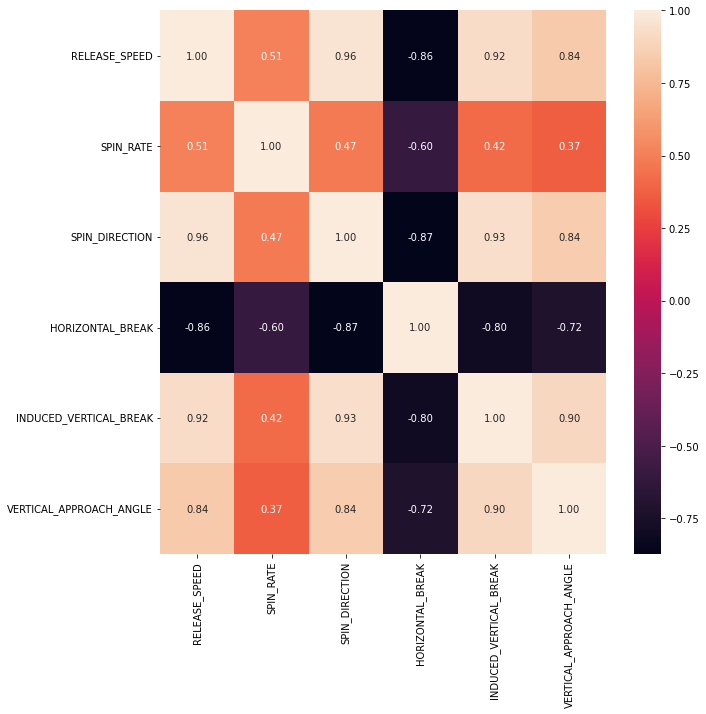

In [37]:
plt.figure(figsize = (10,10))
sns.heatmap(pitcher_a_train.corr(),annot = True, fmt=".2f")

<AxesSubplot:>

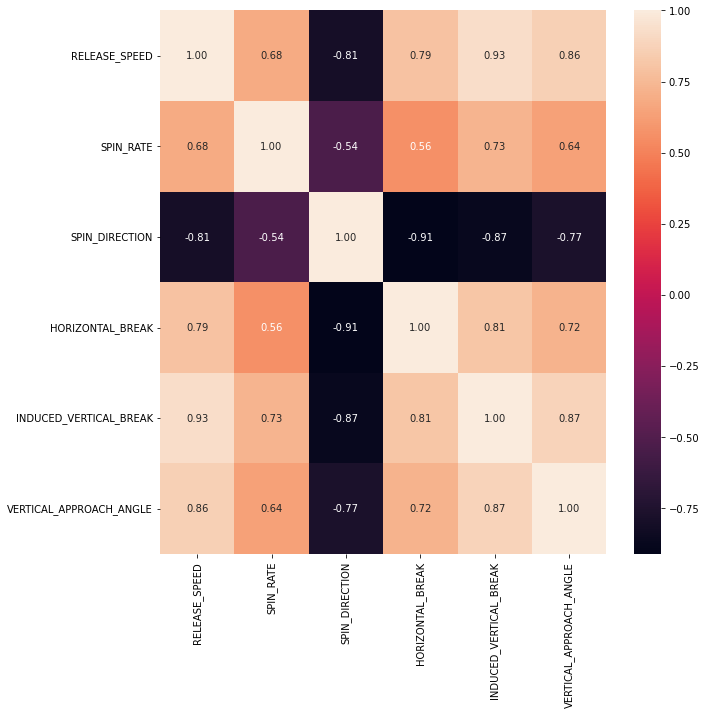

In [38]:
plt.figure(figsize = (10,10))
sns.heatmap(pitcher_b_train.corr(),annot = True, fmt=".2f")

### Create the function that will generate the model and provide some interpretation.

The *evaluate_pitcher* function splits the training data for a given pitcher into a train and test set that will be used to evaluate the residual performance of the model. It will then print the mean and max absolute error of the model and plot the residual data vs actual induced vertical break. Once it produces those means and plots it will generate the predictions for induced vertical break using the evaluation dataframe. In this case, the evaluation dataframe is where the induced vertical break has been changed to NaN values.

In [74]:
def evaluate_pitcher(df_train, df_evaluate):
    df_train.dropna(inplace = True)
    
    X = df_train.drop(columns = 'INDUCED_VERTICAL_BREAK')
    y = df_train['INDUCED_VERTICAL_BREAK']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 3)
    
    rf = RandomForestRegressor(n_estimators = 1000, max_depth = 8, random_state = 3)
    
    rf.fit(X_train,y_train)
    
    predictions = rf.predict(X_test)
    
    residuals = y_test - predictions
    max_error = max(abs(residuals))
    
    print('Mean Error:', round(np.mean(residuals),2))
    print('Max Error:', round(max_error,2))
    
    plt.scatter(residuals,y_test)
    plt.title("Residual Error vs Actual Induced Vertical Break")
    plt.xlabel('Residual Error')
    plt.ylabel('Induced Vertical Break')
    
    df_evaluate.drop(columns = 'INDUCED_VERTICAL_BREAK',inplace = True)
    df_evaluate.dropna(inplace = True)
    df_evaluate['INDUCED_VERTICAL_BREAK'] = rf.predict(df_evaluate)
    
    return df_evaluate

### Model Evaluation

From the results below, the mean error of the model was -0.12 inches of vertical break for each pitcher and it appears as if only a handful of outliers exist (from inspection, outliers being more than 5 inches of vertical break error). In my opinion, these models do an accurate job of predicting induced vertical break given the pitch characteristics used in training. The predictions are stamped valid by me and will be output to a CSV. 

Mean Error: -0.12
Max Error: 19.89


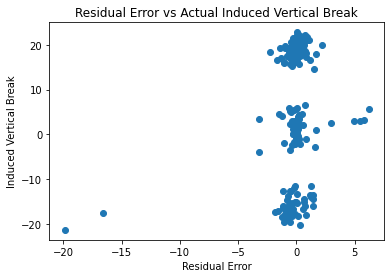

In [75]:
pitcher_a_predicted = evaluate_pitcher(pitcher_a_train.copy(),pitcher_a_predict.copy())

Mean Error: -0.12
Max Error: 9.72


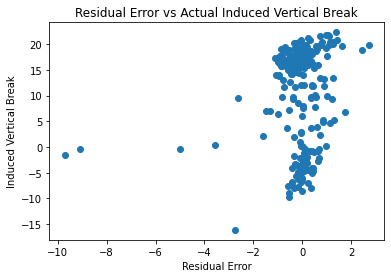

In [76]:
pitcher_b_predicted = evaluate_pitcher(pitcher_b_train.copy(),pitcher_b_predict.copy())

In [253]:
pitcher_a_predicted['PITCHER_KEY'] = 'A'
pitcher_b_predicted['PITCHER_KEY'] = 'B'

out_data = pd.concat([pitcher_a_predicted,pitcher_b_predicted])
out_data = out_data[['PITCHER_KEY','INDUCED_VERTICAL_BREAK']]

out_data.to_csv('./break.csv')

### The below code will be used for questions 2A and 3.

### Question 2A

In [246]:
pitcher_a = pd.concat([pitcher_a_train,pitcher_a_predicted])

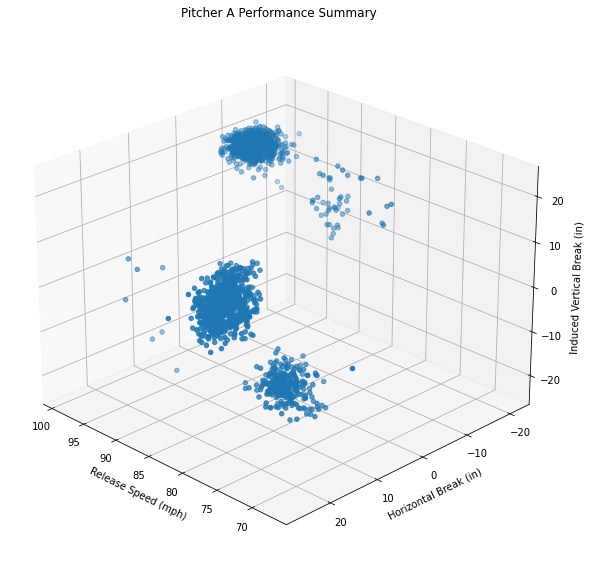

In [184]:
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(projection='3d')

ax.scatter(pitcher_a['RELEASE_SPEED'],pitcher_a['HORIZONTAL_BREAK'],pitcher_a['INDUCED_VERTICAL_BREAK'])
ax.set_title('Pitcher A Performance Summary')
ax.set_xlabel('Release Speed (mph)')
ax.set_ylabel('Horizontal Break (in)')
ax.set_zlabel('Induced Vertical Break (in)')
ax.view_init(25,135)

In [84]:
pitch_types_df = data.copy()

In [207]:
pitcher_a_part2 = pitch_types_df[pitch_types_df['PITCHER_KEY']=='A']
pitcher_a_part2 = pitcher_a_part2[pitcher_a_part2['PITCH_TYPE_KEY']=='CH']
pitcher_a_part2.dropna(subset='INDUCED_VERTICAL_BREAK',inplace=True)
pitcher_a_part2

,GAME_CODE,PITCHER_KEY,THROW_SIDE_KEY,BAT_SIDE_KEY,INNING_KEY,BATTER_IN_INNING_KEY,PITCH_NUMBER,CURRENT_BALLS,CURRENT_STRIKES,PITCH_RESULT_KEY,...,1BO,2BO,3BO,RELEASE_HEIGHT,RELEASE_SIDE,RELEASE_EXTENSION,HORIZONTAL_BREAK,INDUCED_VERTICAL_BREAK,VERTICAL_APPROACH_ANGLE,HORIZONTAL_APPROACH_ANGLE
41,2.022041e+18,A,R,L,3,2,2.0,0,1,FoulBall,...,0,0,0,5.51825,-1.65425,6.53934,-10.050600,10.783400,-5.94006,-0.530191
168,2.022042e+18,A,R,L,1,2,3.0,1,1,StrikeCalled,...,1,0,0,5.45071,-1.57689,6.61594,-10.223300,20.909300,-4.08425,0.418278
169,2.022042e+18,A,R,L,1,2,4.0,1,2,BallCalled,...,1,0,0,5.51602,-1.59047,6.46757,-15.690900,7.891720,-6.37127,-0.519967
197,2.022042e+18,A,R,L,3,1,4.0,3,0,BallCalled,...,0,0,0,5.97310,-1.10621,6.50481,-10.702700,17.983200,-4.69729,-1.006660
198,2.022042e+18,A,R,L,3,2,1.0,0,0,FoulBall,...,1,0,0,5.51370,-1.69089,6.54695,-12.678900,12.741300,-5.89675,-0.544035
202,2.022042e+18,A,R,L,3,2,5.0,1,2,FoulBall,...,1,0,0,5.44623,-1.75745,6.64059,-8.699490,19.117001,-4.04107,1.047400
215,2.022042e+18,A,R,L,4,2,4.0,1,2,BallCalled,...,0,0,0,5.48385,-1.65392,6.62662,-10.326200,17.930901,-4.65751,-0.131973
232,2.022042e+18,A,R,L,5,2,1.0,0,0,InPlay,...,0,0,0,5.57108,-1.70832,6.52483,-6.278120,14.628500,-5.96992,1.878020
500,2.022043e+18,A,R,L,1,4,3.0,0,2,InPlay,...,1,0,0,6.12984,1.02875,5.35865,-15.614400,8.165180,-6.42300,0.307618
535,2.022043e+18,A,R,L,4,2,1.0,0,0,BallCalled,...,0,0,0,5.47356,-1.98411,7.00765,-14.392900,7.978630,-7.14632,1.337580


In [223]:
changeups = data[data['PITCH_TYPE_KEY']=='CH']
changeups = changeups[changeups['PITCHER_KEY'] != 'A']
changeups = changeups[changeups['PITCHER_KEY'] != 'B']
changeups.head(10)

,GAME_CODE,PITCHER_KEY,THROW_SIDE_KEY,BAT_SIDE_KEY,INNING_KEY,BATTER_IN_INNING_KEY,PITCH_NUMBER,CURRENT_BALLS,CURRENT_STRIKES,PITCH_RESULT_KEY,...,1BO,2BO,3BO,RELEASE_HEIGHT,RELEASE_SIDE,RELEASE_EXTENSION,HORIZONTAL_BREAK,INDUCED_VERTICAL_BREAK,VERTICAL_APPROACH_ANGLE,HORIZONTAL_APPROACH_ANGLE
4001,2.022041e+18,663629,L,R,1,1,3.0,2,0,BallCalled,...,0,0,0,6.50277,1.12049,6.78432,13.39550,14.226700,-9.17687,0.356954
4009,2.022041e+18,663629,L,L,1,3,2.0,0,1,BallCalled,...,1,0,0,6.49779,1.20128,6.91736,10.12180,16.136900,-10.43010,-0.816083
4014,2.022041e+18,663629,L,L,1,3,7.0,3,2,BallCalled,...,0,1,0,6.54941,1.18145,6.99648,7.94100,19.011101,-6.98829,-1.942730
4016,2.022041e+18,663629,L,R,1,4,2.0,0,1,BallCalled,...,1,1,0,6.54800,1.46566,6.89294,9.67755,16.948700,-8.35482,-0.776912
4020,2.022041e+18,663629,L,L,1,5,2.0,1,0,BallCalled,...,1,1,0,6.49160,1.37168,6.84591,10.03020,17.866400,-8.04270,-0.929897
4023,2.022041e+18,663629,L,L,1,5,5.0,2,2,StrikeSwinging,...,1,1,0,6.55465,1.45890,6.23985,9.76519,16.684799,-6.97507,-0.926819
4028,2.022041e+18,663629,L,L,2,1,5.0,1,2,StrikeSwinging,...,0,0,0,6.49935,1.35452,6.58382,11.85090,16.161900,-6.72519,-0.190338
4031,2.022041e+18,663629,L,R,2,3,2.0,1,0,BallCalled,...,1,0,0,6.58586,1.32733,7.22073,10.98260,15.690700,-9.23335,-0.854610
4041,2.022041e+18,663629,L,R,2,5,1.0,0,0,BallCalled,...,1,0,1,6.58650,1.35536,6.80278,10.40750,14.427800,-8.66802,-0.044124
4043,2.022041e+18,663629,L,R,2,5,3.0,1,1,BallCalled,...,1,0,1,6.53094,1.58062,6.56662,10.89910,15.243100,-10.48930,-0.628337


In [225]:
cols = ['RELEASE_SPEED','SPIN_RATE','SPIN_DIRECTION','HORIZONTAL_BREAK','INDUCED_VERTICAL_BREAK',
        'VERTICAL_APPROACH_ANGLE','HORIZONTAL_APPROACH_ANGLE']

thresholds = [5,100,10,2,2,5,5]

for ii in range(len(cols)-1):
    changeups = changeups[abs(changeups[cols[ii]] - pitcher_a_part2[cols[ii]].mean()) <= thresholds[ii]]

changeups['PITCH_RESULT_KEY'].value_counts()

BallCalled        112
InPlay             66
FoulBall           57
StrikeSwinging     38
StrikeCalled       36
Name: PITCH_RESULT_KEY, dtype: int64

In [215]:
data['VERTICAL_APPROACH_ANGLE'].head()

0    -6.04305
1    -3.44248
2    -4.40359
3   -12.81380
4    -2.50208
Name: VERTICAL_APPROACH_ANGLE, dtype: float64

In [144]:
pitcher_a['PITCH_TYPE_KEY'].value_counts()

FB    1078
SL     649
CB     256
CH      35
FF      18
UN       1
Name: PITCH_TYPE_KEY, dtype: int64

In [145]:
pitcher_a['PITCH_RESULT_KEY'].value_counts()

BallCalled        751
FoulBall          376
StrikeCalled      351
StrikeSwinging    293
InPlay            247
HitByPitch          8
Name: PITCH_RESULT_KEY, dtype: int64

In [143]:
pitcher_a_results = pitcher_a.groupby(['PITCH_TYPE_KEY'])['PITCH_RESULT_KEY'].value_counts()

In [238]:
def pitch_results_summary(pitcher_results):
    strike_rate = pd.DataFrame()
    total_strikes = 0
    total = 0
    for pitch, new_df in pitcher_results.groupby(level=0):
        total_pitches = 0
        strikes = 0
        for result in new_df.keys():
            if 'Strike' in result[1]:
                strikes += pitcher_results[pitch][result[1]]
                total_strikes += pitcher_results[pitch][result[1]]
                
            total_pitches += pitcher_results[pitch][result[1]]
            total += pitcher_results[pitch][result[1]]
        
        strike_rate[pitch] = pd.Series(strikes/total_pitches)
    
    strike_rate['TOTAL'] = pd.Series(total_strikes/total)
    
    return strike_rate

In [239]:
pitch_results_summary(pitcher_a_results)

,CB,CH,FB,FF,SL,UN,TOTAL
0,0.352941,0.2,0.301869,0.222222,0.340031,0.0,0.317868


In [193]:
pitcher_a_results

PITCH_TYPE_KEY  PITCH_RESULT_KEY
CB              BallCalled          102
                StrikeCalled         62
                FoulBall             39
                StrikeSwinging       28
                InPlay               24
CH              BallCalled           22
                StrikeCalled          4
                FoulBall              3
                InPlay                3
                StrikeSwinging        3
FB              BallCalled          383
                FoulBall            231
                StrikeCalled        172
                StrikeSwinging      151
                InPlay              127
                HitByPitch            6
FF              BallCalled            6
                FoulBall              6
                StrikeSwinging        3
                InPlay                2
                StrikeCalled          1
SL              BallCalled          238
                StrikeCalled        112
                StrikeSwinging      108
       

In [247]:
pitcher_b = pd.concat([pitcher_b_train,pitcher_b_predicted])

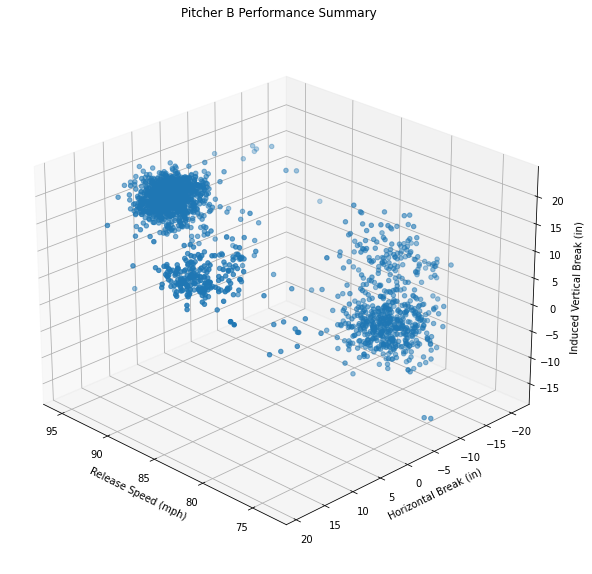

In [182]:
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(projection='3d')

ax.scatter(pitcher_b['RELEASE_SPEED'],pitcher_b['HORIZONTAL_BREAK'],pitcher_b['INDUCED_VERTICAL_BREAK'])
ax.set_title('Pitcher B Performance Summary')
ax.set_xlabel('Release Speed (mph)')
ax.set_ylabel('Horizontal Break (in)')
ax.set_zlabel('Induced Vertical Break (in)')
ax.view_init(25,135)

In [240]:
pitch_results_summary(pitcher_b_results)

,CB,CH,FB,FF,SI,SL,UN,TOTAL
0,0.325678,0.319249,0.280038,0.304348,0.125,0.29932,0.25,0.296827


In [85]:
pitcher_b = pitch_types_df[pitch_types_df['PITCHER_KEY']=='B']
pitcher_b['PITCH_TYPE_KEY'].unique()

array(['FB', 'CB', 'CH', 'FF', 'UN', 'SL', 'SI'], dtype=object)

In [86]:
pitcher_b['PITCH_TYPE_KEY'].value_counts()

FB    1063
CB     480
CH     214
SL     147
FF      46
SI       8
UN       4
Name: PITCH_TYPE_KEY, dtype: int64

In [146]:
pitcher_b['PITCH_RESULT_KEY'].value_counts()

BallCalled        726
FoulBall          367
StrikeCalled      302
StrikeSwinging    278
InPlay            275
HitByPitch          6
Name: PITCH_RESULT_KEY, dtype: int64

In [94]:
pitcher_b_results = pitcher_b.groupby(['PITCH_TYPE_KEY'])['PITCH_RESULT_KEY'].value_counts()

In [229]:
pitcher_b_results

PITCH_TYPE_KEY  PITCH_RESULT_KEY
CB              BallCalled          170
                StrikeSwinging       81
                FoulBall             77
                InPlay               76
                StrikeCalled         75
CH              BallCalled           85
                StrikeSwinging       38
                InPlay               32
                StrikeCalled         30
                FoulBall             28
FB              BallCalled          392
                FoulBall            228
                StrikeCalled        171
                InPlay              136
                StrikeSwinging      125
                HitByPitch            5
FF              BallCalled           25
                StrikeCalled          7
                StrikeSwinging        7
                FoulBall              5
                InPlay                2
SI              FoulBall              5
                BallCalled            2
                StrikeSwinging        1
SL     

In [233]:
pitcher_b_part2 = pitch_types_df[pitch_types_df['PITCHER_KEY']=='B']
pitcher_b_part2 = pitcher_b_part2[pitcher_b_part2['PITCH_TYPE_KEY']=='SI']
pitcher_b_part2.dropna(subset='INDUCED_VERTICAL_BREAK',inplace = True)
pitcher_b_part2

,GAME_CODE,PITCHER_KEY,THROW_SIDE_KEY,BAT_SIDE_KEY,INNING_KEY,BATTER_IN_INNING_KEY,PITCH_NUMBER,CURRENT_BALLS,CURRENT_STRIKES,PITCH_RESULT_KEY,...,1BO,2BO,3BO,RELEASE_HEIGHT,RELEASE_SIDE,RELEASE_EXTENSION,HORIZONTAL_BREAK,INDUCED_VERTICAL_BREAK,VERTICAL_APPROACH_ANGLE,HORIZONTAL_APPROACH_ANGLE
938,2.022051e+18,B,L,R,2,1,5.0,1,2,FoulBall,...,0,0,0,5.74142,1.63161,6.64586,10.6592,8.44655,-6.01873,0.365904
959,2.022051e+18,B,L,R,3,3,3.0,1,1,StrikeSwinging,...,0,0,0,5.72149,1.37976,6.92838,14.8509,11.27770,-7.98098,0.464927
962,2.022051e+18,B,L,R,3,3,6.0,2,2,FoulBall,...,0,0,0,5.72900,1.35142,6.36680,14.2796,11.82900,-7.42439,0.296325
975,2.022051e+18,B,L,R,4,3,2.0,0,1,BallCalled,...,0,0,0,5.69952,1.41528,6.33011,11.6860,12.72050,-8.83706,-0.251336


In [234]:
sinkers = data[data['PITCH_TYPE_KEY']=='SI']
sinkers = sinkers[sinkers['PITCHER_KEY'] != 'A']
sinkers = sinkers[sinkers['PITCHER_KEY'] != 'B']
sinkers

,GAME_CODE,PITCHER_KEY,THROW_SIDE_KEY,BAT_SIDE_KEY,INNING_KEY,BATTER_IN_INNING_KEY,PITCH_NUMBER,CURRENT_BALLS,CURRENT_STRIKES,PITCH_RESULT_KEY,...,1BO,2BO,3BO,RELEASE_HEIGHT,RELEASE_SIDE,RELEASE_EXTENSION,HORIZONTAL_BREAK,INDUCED_VERTICAL_BREAK,VERTICAL_APPROACH_ANGLE,HORIZONTAL_APPROACH_ANGLE
4085,2.022041e+18,592712,R,L,5,5,4.0,1,2,BallCalled,...,1,0,1,6.04560,-1.97871,5.77882,-19.158501,9.48827,-8.08873,1.177350
4091,2.022041e+18,592712,R,R,5,6,2.0,1,0,BallCalled,...,0,1,0,5.93274,-1.99180,6.15533,-17.258301,11.18600,-7.96428,3.565340
4124,2.022041e+18,665001,R,L,7,2,2.0,0,1,StrikeCalled,...,0,0,0,3.68263,-4.11100,6.36587,-19.660601,-1.01006,-5.54851,2.574020
4177,2.022041e+18,643615,R,R,1,1,1.0,0,0,StrikeCalled,...,0,0,0,5.90257,-1.40177,6.91006,-15.902200,6.07867,-5.89006,0.700927
4178,2.022041e+18,643615,R,R,1,1,2.0,0,1,BallCalled,...,0,0,0,5.75443,-1.45029,7.06628,-14.994400,2.61207,-7.40365,3.125560
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
268490,2.022101e+18,670990,R,L,9,1,2.0,1,0,StrikeSwinging,...,0,0,0,4.95724,-2.42147,6.89500,-17.064600,7.82710,-5.00271,0.144953
268491,2.022101e+18,670990,R,L,9,1,3.0,1,1,InPlay,...,0,0,0,4.92587,-2.34635,6.77500,-17.439501,7.35751,-4.79818,0.209142
268492,2.022101e+18,670990,R,R,9,2,1.0,0,0,StrikeSwinging,...,0,0,0,4.98031,-2.34927,6.72500,-17.070299,7.89991,-4.94922,-0.943870
268493,2.022101e+18,670990,R,R,9,2,2.0,0,1,InPlay,...,0,0,0,4.95861,-2.13090,6.76500,-16.516701,8.15600,-5.79083,0.739275


In [235]:
cols = ['RELEASE_SPEED','SPIN_RATE','SPIN_DIRECTION','HORIZONTAL_BREAK','INDUCED_VERTICAL_BREAK',
        'VERTICAL_APPROACH_ANGLE','HORIZONTAL_APPROACH_ANGLE']

thresholds = [5,100,10,2,2,5,5]

for ii in range(len(cols)-1):
    sinkers = sinkers[abs(sinkers[cols[ii]] - pitcher_b_part2[cols[ii]].mean()) <= thresholds[ii]]

sinkers['PITCH_RESULT_KEY'].value_counts()

BallCalled        43
FoulBall          24
StrikeCalled      22
InPlay            18
StrikeSwinging     5
Name: PITCH_RESULT_KEY, dtype: int64